In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler

# Statement of the problem:
The goal is to predict $\{d_t, d_{t+1}..., d_{t+h}\}$, where $h$ is a set time horizon given the previous history of the sequence $d$, i.e., $\{d_{t-1}, d_{t-2}, ... d_{t-l}\}$, where $l$ is a set time lag, in addition to weather observations/predictions $\{f_{t}\}$. Here, $d_t$ represents the energy load consumption, but could represent any other time series we were attempting to forecast, such as the price.

In practice, $h = 1$ for hour-ahead forecasts, and $l$ can in principle be arbitrary. We will to find an optimate value for $l$.

# Solution:

In this notebook, we will attempt a solution based on an LSTM model. The LSTM model will be trained on part of the sequences $d$ and $f$. Once trained, it will attempt to predict $\{d_t, d_{t+1}..., d_{t+h}\}$, taking as immediate input $\{d_{t-1}, d_{t-2}, ... d_{t-l}\}$ and $\{f_{t}\}$ (of course, the the LSTM function itself will also depend on all past entries of $d$ and $f$ through its memory capability).


In [8]:
# IMPORT DATA AND SET LOOK_BACK (l above) and HORIZON (h above)#
energy_df_raw = pd.read_csv('spain energy datasets/energy_dataset.csv')
weather_df_raw = pd.read_csv('spain energy datasets/weather_features.csv')

horizon = 1


### ENERGY DATAFRAME PREPROCESSING ###
energy_df = energy_df_raw.copy()
# Fill missing values with forecast
energy_df.fillna({'total load actual': energy_df['total load forecast']}, inplace = True)
# Keep only time and loads
energy_df = energy_df[['time', 'total load actual', 'total load forecast']]



### WEATHER DATAFRAME PREPROCESSING ###
weather_df = weather_df_raw.copy()
# Keep only time, temperature and city
weather_df = weather_df[['dt_iso','temp','city_name']]
# There are duplicates in date and city, so we drop them
weather_df = weather_df.drop_duplicates(subset = ['dt_iso', 'city_name'])
# Now we pivot the dataframe with respect to the city_name label
weather_df = weather_df.pivot(index = 'dt_iso', columns = 'city_name',
        values = [col for col in weather_df.columns if col not in ['dt_iso', 'city_name']])


# Province Population Dictionary, measured in millions of people (in the case of Bilbao, the entire Basque Country pop is taken because provices there are small)
population_dict = {'Madrid': 7.058, ' Barcelona': 5.878, 'Valencia': 2.606, 'Seville': 1.973, 'Bilbao': 2.208}
population_weights_dict = population_dict.copy()
for key, value in population_weights_dict.items():
  population_weights_dict[key] = value/sum(population_dict.values())

# Convert temperatures to a weighted sum
weather_df = pd.DataFrame((weather_df['temp']*population_weights_dict).sum(axis = 1))
weather_df.columns = ['temp']
weather_df.reset_index(inplace = True)


# CONCATENATE BOTH DATAFRAMES
assert len(energy_df) == len(weather_df), 'The energy and weather dataframes have different lengths'
preprocessed_df = pd.concat([energy_df, weather_df[weather_df['dt_iso'].isin(energy_df['time'])]], axis = 1)
preprocessed_df.drop(columns = ['dt_iso','time'], inplace = True)

#Shift temperature column 24 hours back so that we can align the load input from the current day with the temperature input for the upcoming day
preprocessed_df['temp'] = preprocessed_df['temp'].shift(-horizon)
# The previous shift creates 24 missing entries at the end of the 'temp' column, so we drop them
preprocessed_df.dropna(inplace = True)

print(preprocessed_df.head(24))



    total load actual  total load forecast        temp
0             25385.0              26118.0  272.881211
1             24382.0              24934.0  272.282159
2             22734.0              23515.0  272.276747
3             21286.0              22642.0  272.308334
4             20264.0              21785.0  271.910949
5             19905.0              21441.0  271.930204
6             20010.0              21285.0  272.091525
7             20377.0              21545.0  273.837516
8             20094.0              21443.0  273.951482
9             20637.0              21560.0  274.529370
10            22250.0              22824.0  282.285343
11            23547.0              23720.0  282.708589
12            24133.0              24180.0  282.541017
13            24713.0              24797.0  283.797536
14            24672.0              25222.0  284.381378
15            23528.0              24173.0  280.888734
16            23118.0              23659.0  282.831380
17        

In [11]:
class ElectricityDataset(Dataset):
  def __init__(self, df, all_scaler, target_scaler, look_back, horizon):
    # Only consider the variable 'total load actual'
    # We assume that the features used for the LSTM start at the first entry of df and are given by
    self.data = all_scaler.transform(df.drop(columns = ['total load forecast']).to_numpy())
    self.all_scaler = all_scaler
    self.target_scaler = target_scaler
    self.look_back = look_back
    self.horizon = horizon
    self.length = (len(df)- look_back) //horizon



  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    assert idx >= 0, 'Index out of bounds'
    assert idx <= self.length, 'Index out of bounds'

    X = self.data[self.horizon*idx:self.horizon*idx + self.look_back]
    y = self.data[:, 0][self.horizon*idx + self.look_back:self.horizon*(idx+1) + self.look_back].reshape(-1,1)


    return torch.tensor(X, dtype = torch.float32), torch.tensor(y, dtype = torch.float32)


def generate_datasets(df, train_ratio = 0.7, horizon = 1, look_back = 1):
    train_size = int(train_ratio * len(df))

    # This is the first index, with respect to df, from which test data can be extracted:
    first_test_idx = ((train_size- look_back) //horizon)*horizon + look_back

    train_df = df[:train_size]
    test_df = df[first_test_idx:]

    # Create Standard Scaler and fit to training data
    all_scaler = StandardScaler()
    all_scaler.fit(train_df.drop(columns = 'total load forecast').to_numpy())
    load_scaler = StandardScaler()
    load_scaler.fit(train_df['total load actual'].to_numpy().reshape(-1,1))

    

    # Create training and testing datasets and dataloaders
    train_ds = ElectricityDataset(train_df, all_scaler, load_scaler, look_back, horizon)
    test_ds = ElectricityDataset(test_df, all_scaler, load_scaler, look_back, horizon)

    return train_ds, test_ds

    




# Split data into training and testing dataframes
train_ratio = 0.7

## Create model

In [12]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]).reshape(-1,self.output_size,1)
        return out


## Early Stopping

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = np.Inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## Train model to find optimal look_back

In [14]:
# Identify training device and move model to device
#device = torch.device("cpu")
#model  = model.to(device)


# Loss and optimizer
criterion = torch.nn.MSELoss()


# Training loop
epochs = 150


look_backs = range(1,48,4)
sensitivity = 0.05
best_test_loss = 1.0

look_back_patience = 1
train_patience = 5
delta = 0

look_back_early_stopping = EarlyStopping(look_back_patience, delta)
for look_back in look_backs:
    
    train_ds, test_ds = generate_datasets(preprocessed_df, train_ratio, horizon, look_back)
    train_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)

    n_features = train_ds[0][0].shape[1]

    model = CustomLSTM(n_features, hidden_size = 64, output_size = horizon)
    optimizer = torch.optim.Adam(model.parameters(), lr=10**(-2))

    train_loss_list = []
    test_loss_list = []
    epoch_list = []
    
    train_early_stopping = EarlyStopping(train_patience, delta)

    print(f"\nModel with look_back = {look_back}")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)

            loss = criterion(outputs, labels)
            loss.backward()


            optimizer.step()
            train_loss += loss.item()


        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for features, labels in test_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                test_loss += loss.item()



        epoch_list.append(epoch)
        train_loss_list.append(train_loss/len(train_loader))
        test_loss_list.append(test_loss/len(test_loader))


        
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Test Loss: {test_loss/len(test_loader):.4f}")

        train_early_stopping(test_loss/len(test_loader))
        if train_early_stopping.early_stop == True:
            print(f"Early stopping at epoch {epoch+1}")
            break

    look_back_early_stopping(test_loss/len(test_loader))
    print(f'\nBest test_loss, for varying look_back, so far = {look_back_early_stopping.best_loss:.4f}')
    if look_back_early_stopping.early_stop == False:
        best_model = model
        best_look_back = look_back
        best_train_loss_list = train_loss_list
        best_test_loss_list = test_loss_list
        best_epoch_list = epoch_list
    else:
        break

    
print(f'\nBest look_back = {best_look_back}')
model = best_model
look_back = best_look_back
train_loss_list = best_train_loss_list
test_loss_list = best_test_loss_list
epoch_list = best_epoch_list

train_ds, test_ds = generate_datasets(preprocessed_df, train_ratio, horizon, look_back)
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)




Model with look_back = 1
Epoch 1/150 - Train Loss: 0.1380 - Test Loss: 0.1271
Epoch 6/150 - Train Loss: 0.0974 - Test Loss: 0.1262
Epoch 11/150 - Train Loss: 0.0970 - Test Loss: 0.1188
Epoch 16/150 - Train Loss: 0.0965 - Test Loss: 0.1149
Epoch 21/150 - Train Loss: 0.0961 - Test Loss: 0.1141
Epoch 26/150 - Train Loss: 0.0959 - Test Loss: 0.1132
Epoch 31/150 - Train Loss: 0.0957 - Test Loss: 0.1120
Epoch 36/150 - Train Loss: 0.0956 - Test Loss: 0.1109
Epoch 41/150 - Train Loss: 0.0955 - Test Loss: 0.1103
Epoch 46/150 - Train Loss: 0.0955 - Test Loss: 0.1098
Epoch 51/150 - Train Loss: 0.0954 - Test Loss: 0.1096
Epoch 56/150 - Train Loss: 0.0954 - Test Loss: 0.1094
Epoch 61/150 - Train Loss: 0.0954 - Test Loss: 0.1092
Epoch 66/150 - Train Loss: 0.0953 - Test Loss: 0.1090
Epoch 71/150 - Train Loss: 0.0953 - Test Loss: 0.1088
Epoch 76/150 - Train Loss: 0.0953 - Test Loss: 0.1086
Epoch 81/150 - Train Loss: 0.0953 - Test Loss: 0.1084
Epoch 86/150 - Train Loss: 0.0953 - Test Loss: 0.1082
Epoc

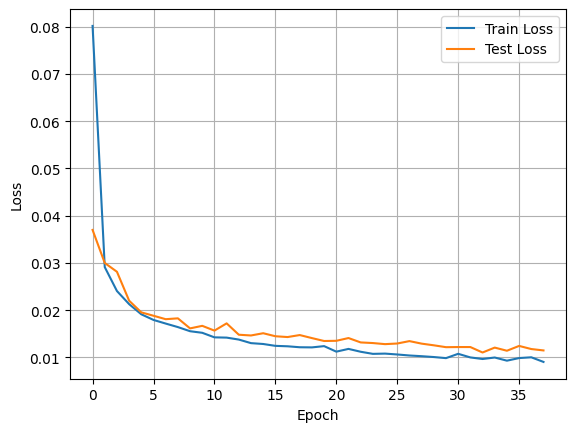

In [15]:
plt.plot(epoch_list,train_loss_list, label = 'Train Loss')
plt.plot(epoch_list,test_loss_list, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

## Train model to find optimal number of layers on LSTM

In [19]:
criterion = nn.MSELoss()

num_layers_list = [1,2,3]
num_layers_patience = 1
num_layers_early_stopping = EarlyStopping(num_layers_patience, delta)


for num_layers in num_layers_list:
    
    train_ds, test_ds = generate_datasets(preprocessed_df, train_ratio, horizon, look_back)
    train_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)
    n_features = train_ds[0][0].shape[1]


    model = CustomLSTM(n_features, hidden_size = 64, output_size = horizon, num_layers = num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=10**(-2))

    train_loss_list = []
    test_loss_list = []
    epoch_list = []
    
    train_early_stopping = EarlyStopping(train_patience, delta)

    print(f"\nModel with num_layers = {num_layers}")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)

            loss = criterion(outputs, labels)
            loss.backward()


            optimizer.step()
            train_loss += loss.item()


        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for features, labels in test_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                test_loss += loss.item()



        epoch_list.append(epoch)
        train_loss_list.append(train_loss/len(train_loader))
        test_loss_list.append(test_loss/len(test_loader))


        
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Test Loss: {test_loss/len(test_loader):.4f}")

        train_early_stopping(test_loss/len(test_loader))
        if train_early_stopping.early_stop == True:
            print(f"Early stopping at epoch {epoch+1}")
            break

    num_layers_early_stopping(test_loss/len(test_loader))
    print(f'\nBest test_loss, for varying number of layers, so far = {num_layers_early_stopping.best_loss:.4f}')
    if num_layers_early_stopping.early_stop == False:
        best_model = model
        best_num_layers = num_layers
        best_train_loss_list = train_loss_list
        best_test_loss_list = test_loss_list
        best_epoch_list = epoch_list
    else:
        break

    
print(f'\nBest num_layers = {best_num_layers}')
model = best_model
num_layers = best_num_layers
train_loss_list = best_train_loss_list
test_loss_list = best_test_loss_list
epoch_list = best_epoch_list

train_ds, test_ds = generate_datasets(preprocessed_df, train_ratio, horizon, look_back)
train_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)


Model with num_layers = 1
Epoch 1/150 - Train Loss: 0.0852 - Test Loss: 0.0323
Epoch 6/150 - Train Loss: 0.0185 - Test Loss: 0.0195
Epoch 11/150 - Train Loss: 0.0150 - Test Loss: 0.0174
Epoch 16/150 - Train Loss: 0.0130 - Test Loss: 0.0144
Epoch 21/150 - Train Loss: 0.0116 - Test Loss: 0.0137
Epoch 26/150 - Train Loss: 0.0107 - Test Loss: 0.0124
Epoch 31/150 - Train Loss: 0.0097 - Test Loss: 0.0120
Epoch 36/150 - Train Loss: 0.0094 - Test Loss: 0.0115
Epoch 41/150 - Train Loss: 0.0089 - Test Loss: 0.0118
Early stopping at epoch 45

Best test_loss, for varying number of layers, so far = 0.0123

Model with num_layers = 2
Epoch 1/150 - Train Loss: 0.0980 - Test Loss: 0.0278
Epoch 6/150 - Train Loss: 0.0155 - Test Loss: 0.0160
Epoch 11/150 - Train Loss: 0.0127 - Test Loss: 0.0137
Epoch 16/150 - Train Loss: 0.0115 - Test Loss: 0.0144
Epoch 21/150 - Train Loss: 0.0104 - Test Loss: 0.0126
Epoch 26/150 - Train Loss: 0.0101 - Test Loss: 0.0131
Early stopping at epoch 26

Best test_loss, for va

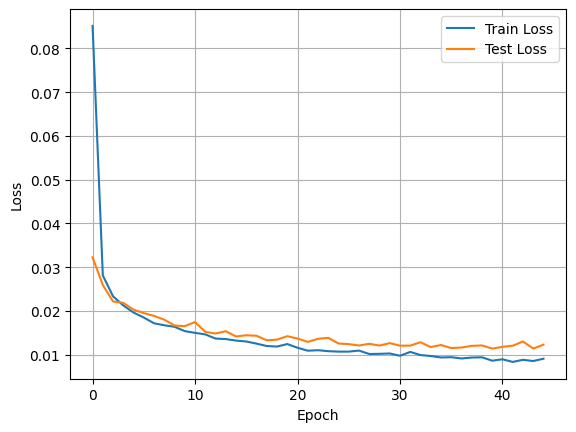

In [20]:
plt.plot(epoch_list,train_loss_list, label = 'Train Loss')
plt.plot(epoch_list,test_loss_list, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

## Plot Prediction Sample and give MAPE

The MAPE (Mean Absolute Percentage Error) is given by the formula

$$MAPE= \frac{100}{T}\sum_{t=0}^T \left|\frac{f_t - \bar{f}_t}{f_t}\right|,$$
where $\bar{f}_t$ are the predicted values and $f_t$ are the observed values.

In [23]:
predict_dl = DataLoader(test_ds, batch_size = 1, shuffle = False)
obs = np.array([])
preds = np.array([])
with torch.no_grad():
  for X, y in predict_dl:
    obs = np.append(obs, test_ds.target_scaler.inverse_transform(y.reshape(-1,1)))
    preds = np.append(preds, test_ds.target_scaler.inverse_transform(model(X).reshape(-1,1)))

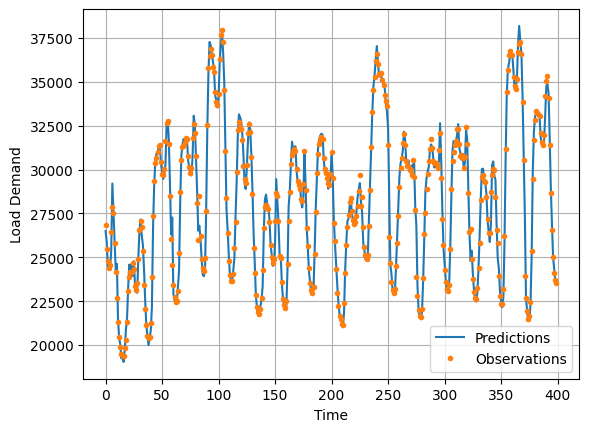

In [25]:
start_offset = 200
end_offset = 600
plt.plot(preds[start_offset:end_offset], label = 'Predictions')
plt.plot(obs[start_offset:end_offset], ls = '', marker = '.', label = 'Observations')
plt.xlabel('Time')
plt.ylabel('Load Demand')
plt.grid()
plt.legend()

In [27]:
MAPE = np.mean(np.abs(1 - preds/obs))*100
MAPE_given = np.mean(np.abs((1 - preprocessed_df['total load forecast'].iloc[first_test_idx:]/preprocessed_df['total load actual'].iloc[first_test_idx:]).to_numpy()))*100
print(f'MAPE of test dataset with LSTM predictions is {MAPE:.4f}%.')
print(f'MAPE of test dataset with predictions given in dataset is {MAPE_given:.4f}%.')

NameError: name 'first_test_idx' is not defined

## Including Time-related Data:
First we proceed to train the LSTM with the same data as before, but also a variable that says whether the day is on the weekend

In [39]:
### ENERGY DATAFRAME PREPROCESSING ###
energy_df = energy_df_raw.copy()
# Fill missing values with forecast
energy_df.fillna({'total load actual': energy_df['total load forecast']}, inplace = True)
# Keep only time and loads
energy_df = energy_df[['time', 'total load actual', 'total load forecast']]



### WEATHER DATAFRAME PREPROCESSING ###
weather_df = weather_df_raw.copy()
# Keep only time, temperature and city
weather_df = weather_df[['dt_iso','temp','city_name']]
# There are duplicates in date and city, so we drop them
weather_df = weather_df.drop_duplicates(subset = ['dt_iso', 'city_name'])
# Now we pivot the dataframe with respect to the city_name label
weather_df = weather_df.pivot(index = 'dt_iso', columns = 'city_name',
        values = [col for col in weather_df.columns if col not in ['dt_iso', 'city_name']])

# Province Population Dictionary, measured in millions of people (in the case of Bilbao, the entire Basque Country pop is taken because provices there are small)
population_dict = {'Madrid': 7.058, ' Barcelona': 5.878, 'Valencia': 2.606, 'Seville': 1.973, 'Bilbao': 2.208}
population_weights_dict = population_dict.copy()
for key, value in population_weights_dict.items():
  population_weights_dict[key] = value/sum(population_dict.values())

# Convert temperatures to a weighted sum
weather_df = pd.DataFrame((weather_df['temp']*population_weights_dict).sum(axis = 1))
weather_df.columns = ['temp']
weather_df.reset_index(inplace = True)


# CONCATENATE BOTH DATAFRAMES AND ADD WEEKEND BOOL VARIABLE
assert len(energy_df) == len(weather_df), 'The energy and weather dataframes have different lengths'
preprocessed_df = pd.concat([energy_df, weather_df[weather_df['dt_iso'].isin(energy_df['time'])]], axis = 1)

preprocessed_df['is_weekend'] = (pd.to_datetime(preprocessed_df['time'], format = 'ISO8601', utc = True).dt.dayofweek >= 5).astype(int)
preprocessed_df.drop(columns = ['dt_iso','time'], inplace = True)

#Shift temperature column 24 hours back so that we can align the load input from the current day with the temperature input for the upcoming day
preprocessed_df[['temp','is_weekend']] = preprocessed_df[['temp', 'is_weekend']].shift(-24)
# The previous shift creates 24 missing entries at the end of the 'temp' column, so we drop them
preprocessed_df.dropna(inplace = True)

print(preprocessed_df.head(24))

    total load actual  total load forecast        temp  is_weekend
0             25385.0              26118.0  273.985599         0.0
1             24382.0              24934.0  273.876766         0.0
2             22734.0              23515.0  273.268827         0.0
3             21286.0              22642.0  273.193631         0.0
4             20264.0              21785.0  273.197252         0.0
5             19905.0              21441.0  272.698875         0.0
6             20010.0              21285.0  272.676222         0.0
7             20377.0              21545.0  272.833251         0.0
8             20094.0              21443.0  274.848934         0.0
9             20637.0              21560.0  274.946072         0.0
10            22250.0              22824.0  275.532990         0.0
11            23547.0              23720.0  278.491024         0.0
12            24133.0              24180.0  281.726146         0.0
13            24713.0              24797.0  283.297792        

<Axes: >

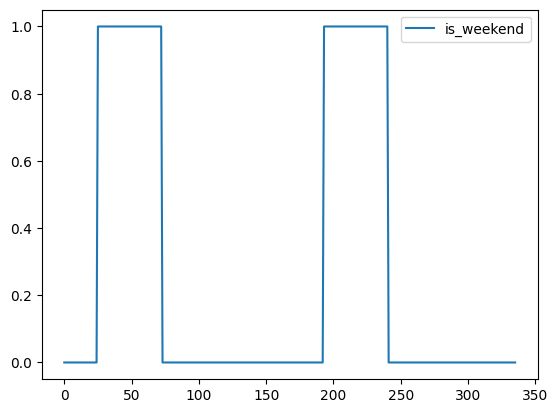

In [40]:
preprocessed_df[['is_weekend']].iloc[:14*24].plot()

In [41]:
train_df = preprocessed_df[:train_size]
test_df = preprocessed_df[first_test_idx:]

# Create Standard Scaler and fit to training data
all_scaler = StandardScaler()
all_scaler.fit(train_df.drop(columns = 'total load forecast').to_numpy())
load_scaler = StandardScaler()
load_scaler.fit(train_df['total load actual'].to_numpy().reshape(-1,1))


# Create training and testing datasets and dataloaders
train_ds = ElectricityDataset(train_df, all_scaler, look_back, horizon)
test_ds = ElectricityDataset(test_df, all_scaler, look_back, horizon)

train_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)

n_features = train_ds[0][0].shape[1]
print(f'Number of features = {n_features}')
train_df.drop(columns = ['total load forecast']).head()

Number of features = 3


,total load actual,temp,is_weekend
0,25385.0,273.985599,0.0
1,24382.0,273.876766,0.0
2,22734.0,273.268827,0.0
3,21286.0,273.193631,0.0
4,20264.0,273.197252,0.0


In [42]:
model = CustomLSTM(n_features, hidden_size = 64, output_size = horizon)

In [44]:
# Identify training device and move model to device
#device = torch.device("cpu")
#model  = model.to(device)


# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10**(-3))

# Training loop
epochs = 250


train_loss_list = []
test_loss_list = []
epoch_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)

        loss = criterion(outputs, labels)
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

        optimizer.step()
        train_loss += loss.item()


    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()



    epoch_list.append(epoch)
    train_loss_list.append(train_loss/len(train_loader))
    test_loss_list.append(test_loss/len(test_loader))



    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Test Loss: {test_loss/len(test_loader):.4f}")

Epoch 1/250 - Train Loss: 0.0251 - Test Loss: 0.0565
Epoch 2/250 - Train Loss: 0.0189 - Test Loss: 0.0545
Epoch 3/250 - Train Loss: 0.0170 - Test Loss: 0.0540
Epoch 4/250 - Train Loss: 0.0159 - Test Loss: 0.0538
Epoch 5/250 - Train Loss: 0.0151 - Test Loss: 0.0537
Epoch 6/250 - Train Loss: 0.0145 - Test Loss: 0.0536
Epoch 7/250 - Train Loss: 0.0140 - Test Loss: 0.0536
Epoch 8/250 - Train Loss: 0.0135 - Test Loss: 0.0536
Epoch 9/250 - Train Loss: 0.0131 - Test Loss: 0.0536
Epoch 10/250 - Train Loss: 0.0128 - Test Loss: 0.0536
Epoch 11/250 - Train Loss: 0.0125 - Test Loss: 0.0535
Epoch 12/250 - Train Loss: 0.0122 - Test Loss: 0.0535
Epoch 13/250 - Train Loss: 0.0120 - Test Loss: 0.0535
Epoch 14/250 - Train Loss: 0.0118 - Test Loss: 0.0535
Epoch 15/250 - Train Loss: 0.0116 - Test Loss: 0.0535
Epoch 16/250 - Train Loss: 0.0114 - Test Loss: 0.0534
Epoch 17/250 - Train Loss: 0.0112 - Test Loss: 0.0535
Epoch 18/250 - Train Loss: 0.0110 - Test Loss: 0.0535
Epoch 19/250 - Train Loss: 0.0109 - T

KeyboardInterrupt: 

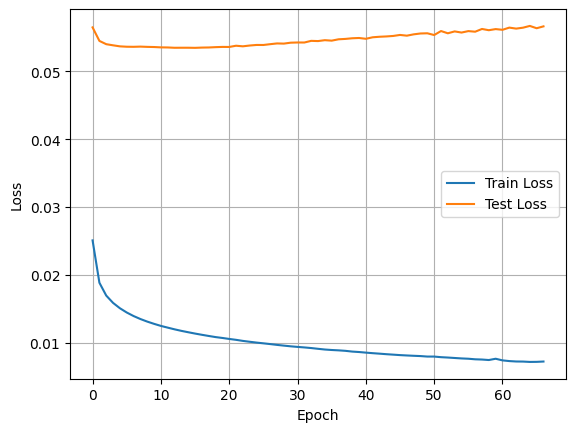

In [45]:
plt.plot(epoch_list, train_loss_list, label = 'Train Loss')
plt.plot(epoch_list, test_loss_list, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [46]:
predict_ds = ElectricityDataset(preprocessed_df, all_scaler, look_back, horizon)
predict_dl = DataLoader(predict_ds, batch_size = 1, shuffle = False)
obs = np.array([])
preds = np.array([])
with torch.no_grad():
  for X, y in predict_dl:
    obs = np.append(obs, load_scaler.inverse_transform(y.reshape(-1,1)))
    preds = np.append(preds, load_scaler.inverse_transform(model(X).reshape(-1,1)))

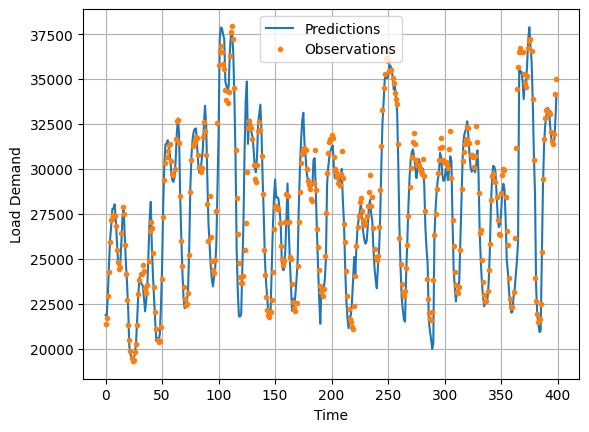

In [47]:
start_offset = 200
end_offset = 600
plt.plot(preds[first_test_idx+start_offset:first_test_idx+end_offset], label = 'Predictions')
plt.plot(obs[first_test_idx+start_offset:first_test_idx+end_offset], ls = '', marker = '.', label = 'Observations')
plt.xlabel('Time')
plt.ylabel('Load Demand')
plt.grid()
plt.legend()

In [48]:
MAPE = np.mean(np.abs(1 - preds[first_test_idx:]/obs[first_test_idx:]))*100
MAPE_given = np.mean(np.abs((1 - preprocessed_df['total load forecast'].iloc[first_test_idx:]/preprocessed_df['total load actual'].iloc[first_test_idx:]).to_numpy()))*100
print(f'MAPE of test dataset with LSTM predictions is {MAPE:.4f}%.')
print(f'MAPE of test dataset with predictions given in dataset is {MAPE_given:.4f}%.')

MASE of test dataset with LSTM predictions is 2.4386%.
MASE of test dataset with predictions given in dataset is 0.9594%.
